<a href="https://colab.research.google.com/github/haterzd/Neural-Networks/blob/main/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Установка дополнительного ПО и библиотек
!apt-get install -q imagemagick # ПО для работы с графическими файлами
!pip install celluloid # библиотека для создания анимации

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsf

In [ ]:
# Подключение библиотек
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
from IPython.display import clear_output, Image
from celluloid import Camera
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image #Для отрисовки изображений
import os
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip -q '/content/drive/MyDrive/Data/archive.zip' -d '/content/eeye'

In [ ]:
img = image.load_img('/content/eeye/femaleeyes/1.jpg', grayscale=True, target_size=(32, 32, 1))
ar = np.asarray(img)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
ar.shape

(32, 32)

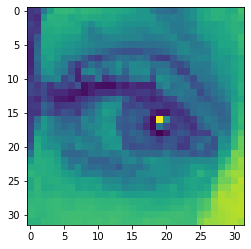

In [ ]:
plt.imshow(ar)

In [ ]:
files_female = os.listdir('/content/eeye/femaleeyes')
files_male = os.listdir('/content/eeye/maleeyes')

In [ ]:
x_train = [] 
y_train = []

for i in range(len(files_female)):
  img_path = '/content/eeye/femaleeyes/' + files_female[i]
  img = image.load_img(img_path, grayscale=True, target_size=(32, 32, 1))
  x_train.append(np.asarray(img))
  y_train.append(0)

for i in range(len(files_male)):
  img_path = '/content/eeye/maleeyes/' + files_male[i]
  img = image.load_img(img_path, grayscale=True, target_size=(32, 32, 1))
  x_train.append(np.asarray(img))
  y_train.append(1)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
len(y_train)

11525

In [ ]:
len(x_train)

11525

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
x_train = x_train / 255
x_train = np.reshape(x_train, (len(x_train), 32, 32, 1)) 

In [ ]:
y_train = to_categorical(y_train, 2)

In [ ]:
print(x_train[0][0][0])
print(y_train[0])

[0.41568627]
[1. 0.]


In [ ]:
print(x_train.shape)
print(y_train.shape)

(11525, 32, 32, 1)
(11525, 2)


In [ ]:
# Основные переменные
batch_size=25 # Размер нашего батча
latent_dim = 32 # размер скрытого слоя
dropout_rate = 0.3 # доля выключаемых нейронов для слоя Dropout
start_lr = 0.0001 # шаг обучения
latent_distrs = [] # список, в котором будем сохранять результаты преобразования изображений, для последующей визуализации
save_epochs = 2 # количество эпох, через которое будем сохранять результаты преобразования изображений
img_height = x_train.shape[1] # высота картинки
img_width = x_train.shape[2] # ширина картинки
img_chanels = x_train.shape[3] # количество каналов картинки

In [ ]:
# Используемые функции

# функция добавления слоев Dropout и BatchNormalization
def apply_bn_and_dropout(x):
  '''
  apply_bn_and_dropout - функция добавления слоев Dropout и BatchNormalization
    вход:
      x - набор слоев, после которых необходимо добавить Dropout и BatchNormalization
      dropout_rate - доля отключенных нейронов (берется из родительской функции)
    выход:
      x - набор слоев с добавленными Dropout и BatchNormalization
  '''
  x = Dropout(dropout_rate) (x) # к слою x добавляем Dropout
  x = BatchNormalization() (x) # к слою x добавляем BatchNormalization
  return x
    
# функция создания собственного слоя
def sampling(args):
  '''
  sampling - функция создания собственного слоя
    вход:
      args - два слоя из котрых возьмем мат.ожидание и ст.отклонение
    выход:
      sampling_layer - собственный слой
  '''
  z_mean, z_log_var = args # раскусываем поданные на вход слои
  epsilon = K.random_normal(shape=(latent_dim,), mean=0., stddev=1.0) # керасовским методом делаем нормальное распределение c мат.ожиданием 0, ст.отклонением 1
  sampling_layer = z_mean + K.exp(z_log_var / 2) * epsilon # изменяем мат.ожидание и ст.отклонение путем сложения и произведения 
  return sampling_layer

# собственная функция ошибки для вариацинного автокодировщика (VAE)
def vae_loss(x, decoded):
  '''
  vae_loss - функция ошибки для VAE
    вход:
      x - истинные картинки (те, что поданы в качестве y)
      decoded - картинки, созданные VAE
    выход:
      res - значение ошибки
  '''
  # num_elements это наши метки, что мы через global получаем за каждую эпоху
  
  kl_loss = -0.5 * K.sum(1.0 + z_log_var_model([x,num_elements]) - K.square(z_mean_model([x,num_elements])) - K.exp(z_log_var_model([x,num_elements])), axis=-1) # по формуле кульбака-лейблера устанавливаем ошибку

  x = K.reshape(x, (-1, img_height*img_width)) # меняем форму для последующего соответствия размеров
  decoded = K.reshape(decoded, (-1, img_height*img_width)) # меняем форму для последующего соответствия размеров
  xent_loss = img_height*img_width*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей

  res = (xent_loss*0.999 + kl_loss*0.001)/img_height/img_width # получаем суммарную ошибку с учетом распределения и размеров пикселей
  return res

In [ ]:
epoch = 0
num_elements = K.constant(y_train[batch_size*epoch:batch_size*(epoch+1)])
def on_epoch_end(epoch, logs):
  '''
  on_epoch_end - функция-callback для отрисовки полученных результатов
    вход:
      epoch - текущая эпоха
      logs - текущее состояние параметров (loss, val_loss)
    выход:
      отрисовка изображений, полученных в результате работы VAE
  '''
  global num_elements
  num_elements = K.constant(y_train[batch_size*epoch:batch_size*(epoch+1)])  # каждый раз переопределяем все метки, чтобы обучение шло хорошо
  if epoch % save_epochs == 0: # если текущая эпоха кратная save_epochs
    clear_output() # очищаем вывод

    real_img = x_train[:10] # берем первые 10 изображений из x_test
    real_img_nums = y_train[:10] # еще раз берем первые 10 изображений из x_test
    pred_img = CVAE.predict([real_img, real_img_nums, real_img_nums]) # пропускаем их через CVAE

    real_img_concat = np.concatenate([i for i in real_img[:,:,:,0]], axis=1) # объединяем 10 исходный изображений по оси 1
    pred_img_concat = np.concatenate([i for i in pred_img[:,:,:,0]], axis=1) # объединяем 10 изображений, пропущенных через СVAE, по оси 1
    plot_img = np.concatenate((real_img_concat, pred_img_concat), axis=0) # объединяем два полученных изображения в одно по оси 0
    latent_distrs.append(plot_img) # итоговое изображение добавляем в список для последующего анимирования результата

    plt.figure(figsize=(2*img_height, 2*len(real_img)), dpi=25) # создаем фигуру
    plt.imshow(plot_img, cmap='Greys_r') # отрисовываем итоговое изображение
    plt.grid(False) # убираем сетку
    plt.axis('off') # выключаем оси
    plt.show() # выводим результат

pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
# Создание энкодера на полносвязных слоях
en_in = Input((img_height, img_width, img_chanels)) # входной слой
# en = Flatten() (en_in) # разворачиванние входного массива для использования полносвязных слоев
class_1 = Input(shape=(2,))  # Дополнительным входом подаём метки в виде OHE на 10 элементов(кол-во классов)
conv = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(en_in)
conv = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(conv)
conv = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(conv)
conv = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(conv)
conv = Flatten()(conv)
en = concatenate([conv, class_1]) # Соединяем наши входные слои
en = Dense(256, activation='relu') (en) # подключение полносвязного слоя на 256 нейронов


z_mean = Dense(latent_dim) (en) # скрытое пространство (мат.ожидание) размером latent_dim
z_log_var = Dense(latent_dim) (en) # скрытое пространство (лог.вариации) размером latent_dim

l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])  # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (latent_dim,)

# Создание декодера на полносвязных слоях
dec_in = Input(shape =(latent_dim,)) # задаем входную размерность
class_2 = Input(shape=(2,))
dec = concatenate([dec_in, class_2])

dec = Dense(256) (dec) # полносвязный слой на 256 нейронов
dec = LeakyReLU()(dec) # применяем функцию активации отдельным слоем

dec = Dense(2*2*256, activation='relu') (dec) # полносвязный слой на 784 нейрона
dec = Reshape((2, 2, 256)) (dec)  # меняем форму, приводим к нужным нам размерам
dec = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(dec)
dec = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(dec)
dec = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(dec)
dec = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(dec)
dec = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec)
# создание необходимых моделей
encoder = Model([en_in, class_1], l) # собираем модель энкодера от входа до лямбда слоя и добавляем доп входом нашу первую метку

decoder = Model([dec_in, class_2], dec) # собираем модель декодераи добавляем доп входом нашу вторую метку

z_mean_model = Model([en_in, class_1], z_mean)  # отдельная модель с путем от входов до z_mean

z_log_var_model = Model([en_in, class_1], z_log_var) # отдельная модель с путем от входов до z_log_v    ar

style = Model([en_in, class_1, class_2], decoder([z_mean_model([en_in, class_1]), class_2]))
CVAE = Model([en_in, class_1, class_2], decoder([encoder([en_in, class_1]), class_2])) # собираем вариационный автокодировщик с условием, также двойное преобразование над входной картинкой(энкодер-декодер)

In [ ]:
# Компиляция CVAE с применением собственной функции ошибки
CVAE.compile(loss=vae_loss, optimizer=Adam(start_lr))

In [ ]:
CVAE.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 32)           667200      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 2)]          0                                     

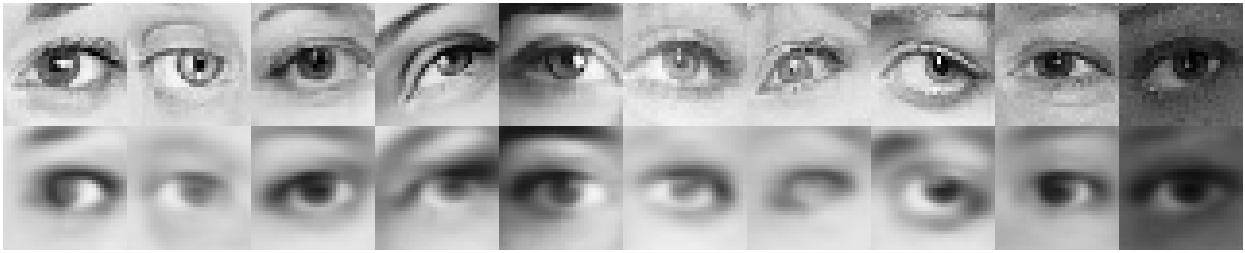

Epoch 10/10
461/461 [==============================] - 107s 232ms/step - loss: 0.6022


In [ ]:
# Обучение CVAE
CVAE.fit([x_train, y_train, y_train], x_train, batch_size=batch_size, epochs=30, verbose=1, callbacks=[pltfig])